In [1]:

import tensorflow as tf
print(tf.__version__)


/Users/chidam_sp/codify_odi/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


2.14.0


In [2]:

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:

import numpy as np
import matplotlib.pyplot as plt
import gc
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit


def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


In [4]:

def plot_series_1(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()



In [5]:

!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv


--2024-02-09 15:12:37--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.007s  

2024-02-09 15:12:37 (9.53 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [6]:

import pandas as pd

df = pd.read_csv('/tmp/daily-min-temperatures.csv')




In [8]:
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [7]:
import os
os.getcwd()

'/Users/chidam_sp'

In [9]:
#Let's save a copy of this file in local

df.to_csv("/Users/chidam_sp/daily_min_temperatures_week4_sequential_time_series_coursera.csv", index=False) 


In [10]:

len(df)


3650

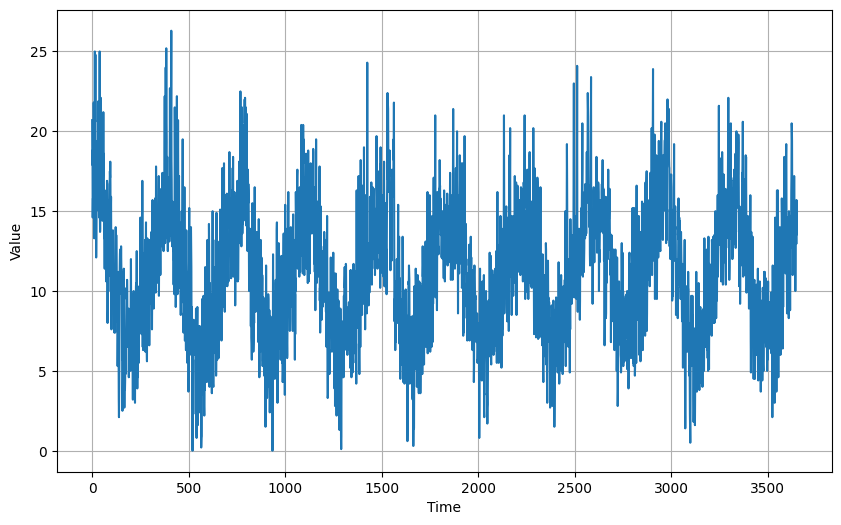

In [11]:

import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step = 0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)


In [12]:

split_time = 3000

# Get the train set 
time_train = time[:split_time]# YOUR CODE HERE
x_train = series[:split_time]# YOUR CODE HERE

# Get the validation set
time_valid = time[split_time:]# YOUR CODE HERE
x_valid = series[split_time:]# YOUR CODE HERE


In [13]:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) ##the None dimension invoked by window.batch is 
    ##of course necessary 

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))


    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset


In [14]:

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
# print(x_train.shape)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


2024-02-09 15:19:15.889571: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-02-09 15:19:15.889598: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-09 15:19:15.889608: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-09 15:19:15.889839: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-09 15:19:15.890224: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [31]:

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.legacy.SGD(momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


In [32]:

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
93/93 [==============================] - 4s 24ms/step - loss: 2.2191 - mae: 2.6753 - lr: 1.0000e-06
Epoch 2/100
 4/93 [>.............................] - ETA: 2s - loss: 2.4903 - mae: 2.9628

2024-02-09 15:36:19.889207: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1426798262152422075
2024-02-09 15:36:19.889220: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17166175910712303287
2024-02-09 15:36:19.889229: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9275917010833635026


93/93 [==============================] - 2s 22ms/step - loss: 1.9804 - mae: 2.4359 - lr: 1.1220e-06
Epoch 3/100
93/93 [==============================] - 2s 23ms/step - loss: 1.8826 - mae: 2.3367 - lr: 1.2589e-06
Epoch 4/100
93/93 [==============================] - 2s 23ms/step - loss: 1.8775 - mae: 2.3308 - lr: 1.4125e-06
Epoch 5/100
93/93 [==============================] - 2s 22ms/step - loss: 1.7580 - mae: 2.2101 - lr: 1.5849e-06
Epoch 6/100
93/93 [==============================] - 2s 22ms/step - loss: 1.8811 - mae: 2.3342 - lr: 1.7783e-06
Epoch 7/100
93/93 [==============================] - 2s 23ms/step - loss: 1.7528 - mae: 2.2028 - lr: 1.9953e-06
Epoch 8/100
93/93 [==============================] - 2s 23ms/step - loss: 1.6854 - mae: 2.1347 - lr: 2.2387e-06
Epoch 9/100
93/93 [==============================] - 2s 23ms/step - loss: 1.6724 - mae: 2.1233 - lr: 2.5119e-06
Epoch 10/100
93/93 [==============================] - 2s 22ms/step - loss: 1.6499 - mae: 2.0979 - lr: 2.8184e-06
Epo

In [34]:

min(history.history["loss"])


1.6285802125930786

In [36]:

min(history.history["lr"])


1e-06

In [45]:

max(history.history["lr"])


0.0891251

In [39]:

# history.history["lr"]


(1e-06, 0.01, 0.0, 10.0)

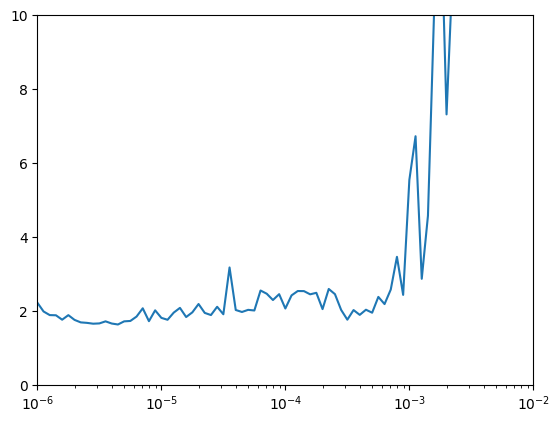

In [43]:

plt.semilogx(history.history["lr"], history.history["loss"])

# Set the plot boundaries
plt.axis([1e-6, 1e-2, 0, 10])


In [46]:

del epoch, model, history


In [29]:

for epoch in range(1, 10):
    print(1e-8 * 10**(epoch / 20))


1.1220184543019634e-08
1.2589254117941673e-08
1.4125375446227544e-08
1.5848931924611136e-08
1.7782794100389228e-08
1.9952623149688796e-08
2.2387211385683395e-08
2.51188643150958e-08
2.8183829312644537e-08


In [28]:
1.1220184543019634*(1/(10^8))

0.5610092271509817

In [30]:

2.8183829312644537*(1/(10^8))


1.4091914656322269

In [47]:

# Reset states generated by Keras
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-06

optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])




In [48]:

# Train the model
history = model.fit(train_set, epochs=100)


Epoch 1/100
93/93 [==============================] - 4s 25ms/step - loss: 7.5691 - mae: 8.0457
Epoch 2/100
 4/93 [>.............................] - ETA: 2s - loss: 3.0906 - mae: 3.5589

2024-02-09 15:48:58.888482: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1426798262152422075
2024-02-09 15:48:58.888493: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11545495348418722317
2024-02-09 15:48:58.888499: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13647998508930446242


93/93 [==============================] - 2s 23ms/step - loss: 2.5346 - mae: 2.9976
Epoch 3/100
93/93 [==============================] - 2s 22ms/step - loss: 2.2428 - mae: 2.7047
Epoch 4/100
93/93 [==============================] - 2s 23ms/step - loss: 2.0892 - mae: 2.5496
Epoch 5/100
93/93 [==============================] - 2s 22ms/step - loss: 1.9624 - mae: 2.4182
Epoch 6/100
93/93 [==============================] - 2s 22ms/step - loss: 1.8906 - mae: 2.3427
Epoch 7/100
93/93 [==============================] - 2s 22ms/step - loss: 1.8338 - mae: 2.2883
Epoch 8/100
93/93 [==============================] - 2s 22ms/step - loss: 1.7945 - mae: 2.2466
Epoch 9/100
93/93 [==============================] - 2s 22ms/step - loss: 1.7548 - mae: 2.2033
Epoch 10/100
93/93 [==============================] - 2s 22ms/step - loss: 1.7444 - mae: 2.1958
Epoch 11/100
93/93 [==============================] - 2s 22ms/step - loss: 1.7238 - mae: 2.1741
Epoch 12/100
93/93 [==============================] - 2s 22m

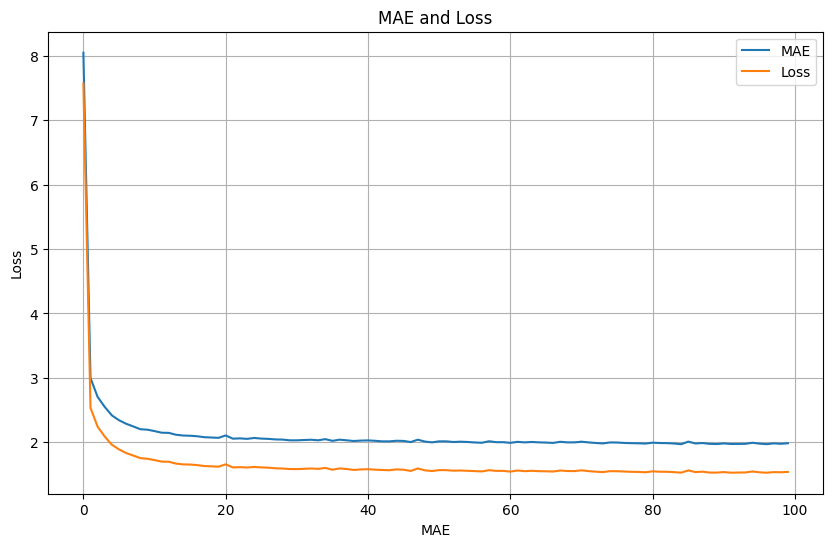

In [49]:

# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series_1(x=epochs, y=(mae, loss), title='MAE and Loss', xlabel='MAE', ylabel='Loss', legend=['MAE', 'Loss'])



In [50]:

min(history.history['loss']), max(history.history['loss'])


(1.5279911756515503, 7.569126129150391)

In [51]:

def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast



21/21 [==============================] - 1s 19ms/step


2024-02-09 16:22:01.421352: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9229862529536520892


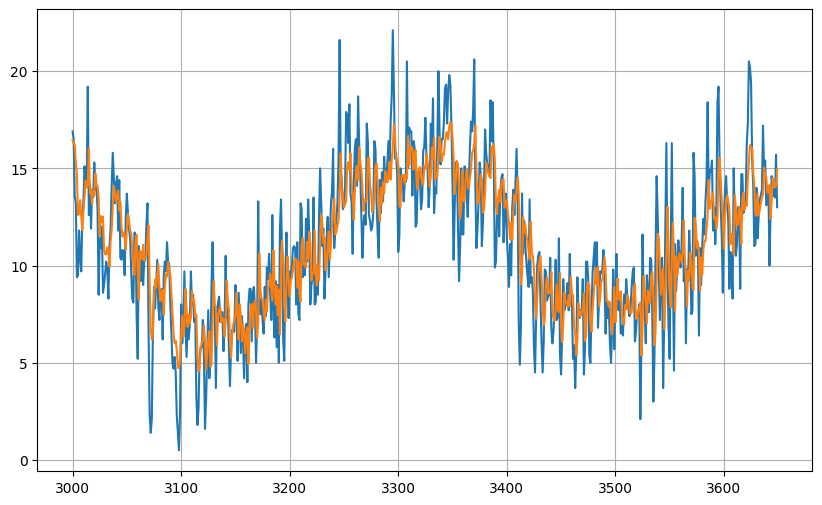

In [52]:

# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series_1(time_valid, (x_valid, results))
# plot_series_1(time_valid, x_valid)
# plot_series_1(time_valid, results)


In [53]:

# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())


1.7775288
